In [1]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import skimage
import skimage.io
import scipy.io as sio
import skimage.transform
import sys

np.random.seed(0)

VGG_MEAN = [103.939, 116.779, 123.68]

def read_mat(path):
    return np.load(path)

def write_mat(path, m):
    np.save(path, m)

def read_ids(path):
    return [line.rstrip('\n') for line in open(path)]


import matplotlib.pyplot as plt
import os
import tensorflow as tf
import cv2
import json
from collections import namedtuple
from tqdm import tqdm
from train_depth import initialize_model

In [2]:
outputChannels = 16
classType = 'unified_CR'
# 0 leaf --> background?
indices = [0]
savePrefix = "direction_" + classType + "_unified_CR_pretrain"
batchSize = 2
learningRate = 1e-5
# learningRateActual = 1e-7
wd = 1e-5
initialIteration = 1
train = False

In [3]:
from ioUtils import *

In [4]:
valFeeder = Batch_Feeder(dataset_path="../../watershednet/data/for_training/42/", 
                           indices=indices,
                           subset='test',
                           batchSize=5,
                           padWidth=None,
                           padHeight=None, 
                           flip=False,
                           keepEmpty=False,
                           train=True,
                           img_shape = (384,384))
valFeeder.set_paths()

        

scanning ../../watershednet/data/for_training/42/test


In [5]:
# train_model(model=model, outputChannels=outputChannels,
#             learningRate=learningRate,
#             trainFeeder=trainFeeder, valFeeder=valFeeder,
#             modelSavePath="../models/direction", savePrefix=savePrefix,
#             initialIteration=initialIteration)

In [6]:
!ls ../models/depth/depth_unified_CR_CR_pretrain_300.mat

../models/depth/depth_unified_CR_CR_pretrain_300.mat


In [7]:
modelWeightPaths = ["../models/depth/depth_unified_CR_CR_pretrain_300.mat"]

In [8]:
from train_depth import initialize_model

In [9]:
import math

In [10]:
#modelWeightPaths = ["./cityscapes/models/direction/direction3_unified_ss_wide_pretrain_VGGFIX_020.mat"]

model = initialize_model(outputChannels=outputChannels, wd=0, modelWeightPaths=modelWeightPaths)

# feeder = Batch_Feeder(dataset="cityscapes", indices=indices, train=train, batchSize=batchSize, padWidth=None, padHeight=None)
# feeder.set_paths(idList=read_ids("./cityscapes/splits/vallist.txt"),
#                  imageDir="./cityscapes/inputImages/val",
#                  ssDir="./cityscapes/unified/ssMaskFineGT/val")



In [11]:
import math
batchSize = 8

In [12]:
with tf.Session() as sess:
    tfBatchDirs = tf.placeholder("float", shape=[None, 384, 384, 2])
    tfBatchGT = tf.placeholder("float", shape=[None, 384, 384])
    #tfBatchWeight = tf.placeholder("float")
    tfBatchSS = tf.placeholder("float", shape=[None, 384, 384])
    keepProb = tf.placeholder("float")

    with tf.name_scope("model_builder"):
        print ("attempting to build model")
        model.build(tfBatchDirs, tfBatchSS, keepProb=keepProb)
        print ("built the model")
    sys.stdout.flush()

    init = tf.initialize_all_variables()
    sess.run(init)
    
    
    for i in tqdm(range(int(math.floor(valFeeder.total_samples() / batchSize)))):

        dirBatch, gtBatch, ssBatch= valFeeder.next_batch()
        
        outputBatch = sess.run(model.outputDataArgMax, feed_dict={tfBatchDirs: dirBatch,
                                              tfBatchGT: gtBatch,
                                              tfBatchSS: ssBatch,
                                              keepProb: 0.7})
        
        

#         for j in range(len(idBatch)):
#             outputFilePath = os.path.join(outputSavePath, idBatch[j]+'.mat')
#             outputFileDir = os.path.dirname(outputFilePath)

#             if not os.path.exists(outputFileDir):
#                 os.makedirs(outputFileDir)

#             sio.savemat(outputFilePath, {"dir_map": outputBatch[j]}, do_compression=True)

#             print ("processed image %d out of %d"%(j+batchSize*i, feeder.total_samples()))



attempting to build model

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor

loaded depth/conv1_1/weights


loaded depth/conv1_1/biases
loaded depth/conv1_2/weights
loaded depth/conv1_2/biases

loaded depth/conv2_1/weights
loaded depth/conv2_1/biases
loaded depth/conv2_2/weights
loaded depth/conv2_2/biases
loaded depth/conv2_3/weights
loaded depth/conv2_3/biases
loaded depth/conv2_4/weights
loaded depth/conv2_4/biases
loaded depth/fcn1/weights
loaded depth/fcn1/biases
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
loaded depth/fcn2/weights
loaded depth/fcn2/biases
loaded depth/upscore/up_filter
Instructions for updating:
Use the `axis` argument instead
built the model
Instructions for updating:
Use `tf.global_variables_initializer` instead.


100%|██████████| 5/5 [00:04<00:00,  1.21it/s]


In [ ]:
outputBatch.shape

In [15]:
import matplotlib.pyplot as plt

In [14]:
plt.imshow(gt)

NameError: name 'gt' is not defined

In [20]:
ind=1

In [21]:
depth = outputBatch[ind]
gt = gtBatch[ind]
ss = ssBatch[ind]

Text(0.5, 1.0, 'semantic seg: ground truth')

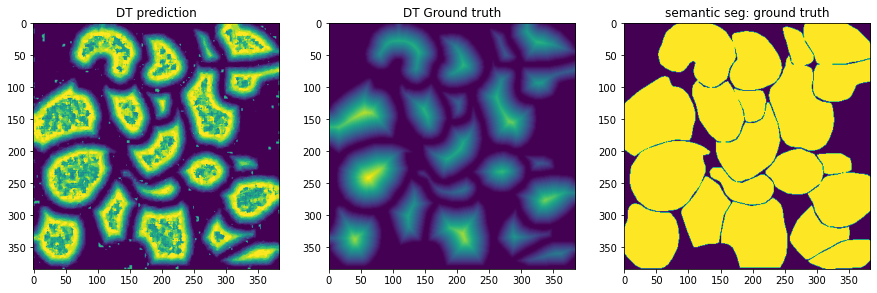

In [22]:
plt.figure(figsize=(15,15))
plt.subplot(131)
plt.imshow(depth)
plt.title("DT prediction")
plt.subplot(132)
plt.imshow(gt)
plt.title("DT Ground truth")
plt.subplot(133)
plt.imshow(ss)
plt.title("semantic seg: ground truth")

In [19]:
from skimage import io, morphology
import skimage
import itertools

from scipy import ndimage as ndi

In [23]:
ccImage = (depth>0.5)*ss
ccImage = ccImage.astype(np.bool)
ccImage = skimage.morphology.remove_small_objects(ccImage, min_size=200)
ccImage = skimage.morphology.remove_small_holes(ccImage)
labeled_image, labels = skimage.morphology.label(ccImage, neighbors=4,background=0, return_num=True)
print("[*] detected {} intial regions".format(labels))

[*] detected 14 intial regions


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: The argument 'neighbors' is deprecated and will be removed in scikit-image 0.18, use 'connectivity' instead. For neighbors=4, use connectivity=1
  """


In [24]:
# labeled_image, labels = skimage.measure.label(img, neighbors = 8, connectivity=2, return_num=True)
# print("[*] detected {} intial regions".format(labels))

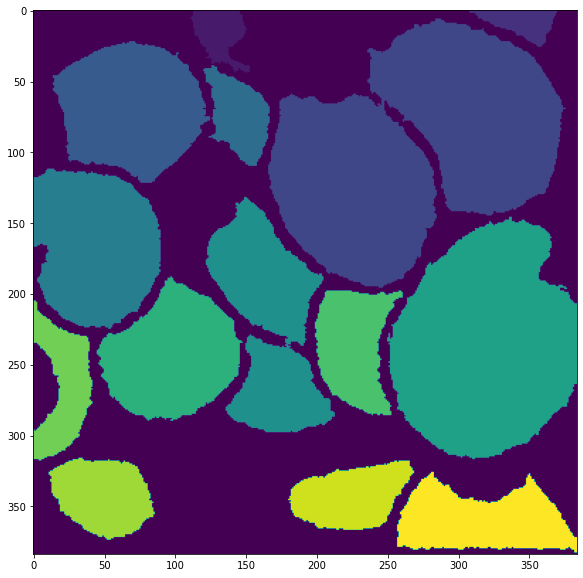

In [25]:
plt.figure(figsize=(10,10))
plt.imshow(labeled_image)

In [ ]:
obj_ids = np.unique(labeled_image)[1:]
lvs = labeled_image == obj_ids[:, None, None]

In [ ]:
CLASS_TO_SS = {"leaf":128, "rider":-96, "motorcycle":-64,
               "bicycle":-32, "car":32, "truck":64, "bus":96, "train":128}
CLASS_TO_CITYSCAPES = {"person":24, "rider":25, "motorcycle":32,
               "bicycle":33, "car":26, "truck":27, "bus":28, "train":31}
THRESHOLD = {"person":1, "rider":1, "motorcycle":1, "bicycle":1,
             "car":2, "truck":2, "bus":2, "train":2}
MIN_SIZE = {"person":20, "rider":20, "motorcycle":20, "bicycle":20,
            "car":25, "truck":45, "bus":45, "train":45}
SELEM = {1: (np.ones((3,3))).astype(np.bool),
         2: (np.ones((5,5))).astype(np.bool)}

In [81]:
skimage.morphology.binary_dilation()

Signature: skimage.morphology.binary_dilation(image, selem=None, out=None)
Docstring:
Return fast binary morphological dilation of an image.

This function returns the same result as greyscale dilation but performs
faster for binary images.

Morphological dilation sets a pixel at ``(i,j)`` to the maximum over all
pixels in the neighborhood centered at ``(i,j)``. Dilation enlarges bright
regions and shrinks dark regions.

Parameters
----------

image : ndarray
    Binary input image.
selem : ndarray, optional
    The neighborhood expressed as a 2-D array of 1's and 0's.
    If None, use a cross-shaped structuring element (connectivity=1).
out : ndarray of bool, optional
    The array to store the result of the morphology. If None is
    passed, a new array will be allocated.

Returns
-------
dilated : ndarray of bool or uint
    The result of the morphological dilation with values in
    ``[False, True]``.
File:      /usr/local/lib/python3.7/site-packages/skimage/morphology/binary.py
Ty

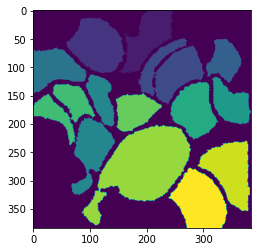

In [88]:
plt.imshow(ccLabels)

In [78]:
ssMask = ss.astype(np.int32)
resultImage = np.zeros(shape=ssMask.shape, dtype=np.float32)


ccImage = (depth>0.5)*ss
ccImage = ccImage.astype(np.bool)
ccImage = skimage.morphology.remove_small_objects(ccImage, min_size=200)
ccImage = skimage.morphology.remove_small_holes(ccImage)
ccLabels = skimage.morphology.label(ccImage)

ccIDs = np.unique(ccLabels)[1:]
for ccID in ccIDs:
    ccIDMask = (ccLabels == ccID)
    ccIDMask = skimage.morphology.binary_dilation(ccID, SELEM[1])
    instanceID = ccID
    resultImage[ccIDMask] = instanceID

resultImage = resultImage.astype(np.uint16)

RuntimeError: structure and input must have same dimensionality

In [75]:
ccImage.astype(np.float32)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

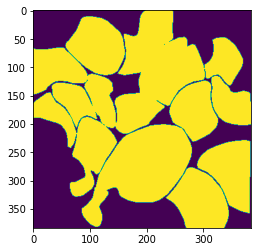

In [64]:
plt.imshow(ss.astype(np.bool))

In [53]:
import scipy.ndimage.interpolation
import scipy.misc
import skimage.morphology
import numpy as np

#CS codes: 24: person, 25: rider, 32: motorcycle, 33: bicycle, 26: car, 27: truck, 28: bus, 31: train
#PSP SS codes:
# CLASS_TO_SS = {"person":12, "rider":13, "motorcycle":18,
#                "bicycle":19, "car":13, "truck":15, "bus":16, "train":17}
CLASS_TO_SS = {"person":-128, "rider":-96, "motorcycle":-64,
               "bicycle":-32, "car":32, "truck":64, "bus":96, "train":128}
CLASS_TO_CITYSCAPES = {"person":24, "rider":25, "motorcycle":32,
               "bicycle":33, "car":26, "truck":27, "bus":28, "train":31}
THRESHOLD = {"person":1, "rider":1, "motorcycle":1, "bicycle":1,
             "car":2, "truck":2, "bus":2, "train":2}
MIN_SIZE = {"person":20, "rider":20, "motorcycle":20, "bicycle":20,
            "car":25, "truck":45, "bus":45, "train":45}
SELEM = {1: (np.ones((3,3))).astype(np.bool),
         2: (np.ones((5,5))).astype(np.bool)}

In [54]:
def watershed_cut(depthImage, ssMask):
    ssMask = ssMask.astype(np.int32)
    resultImage = np.zeros(shape=ssMask.shape, dtype=np.float32)

    for semClass in CLASS_TO_CITYSCAPES.keys():
        csCode = CLASS_TO_CITYSCAPES[semClass]
        ssCode = CLASS_TO_SS[semClass]
        ssMaskClass = (ssMask == ssCode)

        ccImage = (depthImage > THRESHOLD[semClass]) * ssMaskClass
        ccImage = skimage.morphology.remove_small_objects(ccImage, min_size=MIN_SIZE[semClass])
        ccImage = skimage.morphology.remove_small_holes(ccImage)
        ccLabels = skimage.morphology.label(ccImage)

        ccIDs = np.unique(ccLabels)[1:]
        for ccID in ccIDs:
            ccIDMask = (ccLabels == ccID)
            ccIDMask = skimage.morphology.binary_dilation(ccIDMask, SELEM[THRESHOLD[semClass]])
            instanceID = 1000 * csCode + ccID
            resultImage[ccIDMask] = instanceID

    resultImage = resultImage.astype(np.uint16)
    return resultImage

In [ ]:
def forward_model(model, feeder, outputSavePath):
    with tf.Session() as sess:
        tfBatchImages = tf.placeholder("float", shape=[None, 384, 384, 3])
        tfBatchGT = tf.placeholder("float", shape=[None, 384, 384, 2])
        tfBatchSS = tf.placeholder("float", shape=[None, 384, 384])

        with tf.name_scope("model_builder"):
            print ("attempting to build model")
            model.build(tfBatchImages, tfBatchSS)
            print ("built the model")
        sys.stdout.flush()

        init = tf.initialize_all_variables()
        sess.run(init)

        for i in range(int(math.floor(feeder.total_samples() / batchSize))):
            imageBatch, ssBatch, ssMaskBatch, idBatch = feeder.next_batch()

            outputBatch = sess.run(model.output, feed_dict={tfBatchImages: imageBatch, tfBatchSS: ssBatch, tfBatchSSMask: ssMaskBatch})

            for j in range(len(idBatch)):
                outputFilePath = os.path.join(outputSavePath, idBatch[j]+'.mat')
                outputFileDir = os.path.dirname(outputFilePath)

                if not os.path.exists(outputFileDir):
                    os.makedirs(outputFileDir)

                sio.savemat(outputFilePath, {"dir_map": outputBatch[j]}, do_compression=True)

                print ("processed image %d out of %d"%(j+batchSize*i, feeder.total_samples()))


In [ ]:
forward_model(model, feeder=feeder,
              outputSavePath="./training/output/direction_ss")